# Imports

In [28]:
import pyabf
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal


# Set Paths

In [29]:
# Define the project path and a list of 5 ABF file names
project_path = 'C:\\Users\\ikmor\\OneDrive\\Documents\\SNR AND OBR pilot study\\'

abf_files_set1 = [
    f'{project_path}PTX10 CNQX A3.abf',
    f'{project_path}DS5L4 ACCOM.abf',
    f'{project_path}DS5R2 ACCOM.abf',
    f'{project_path}DS4 ACCOM.abf'
]
abf_files_set2 = [
    f'{project_path}PTX10 CNQX APPLIED A3.abf',
    f'{project_path}DS5L4CNQX ACCOM.abf',
    f'{project_path}DS5R2 CNQX ACCOM.abf',
    f'{project_path}DS4CNQX ACCOM.abf']


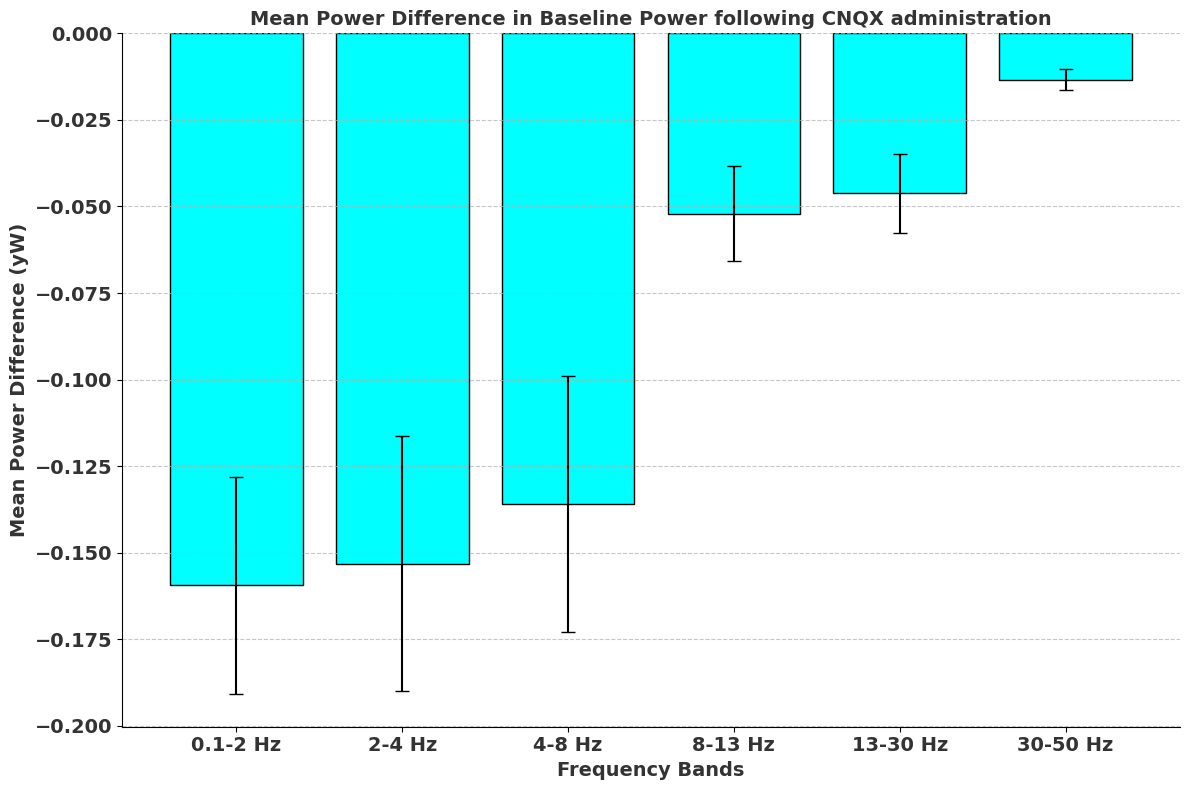

Mean Power Differences and Standard Errors for Each Frequency Band:
0.1-2 Hz: Mean = -1.594326e-01 yW, SE = 3.128189e-02 yW
2-4 Hz: Mean = -1.531488e-01 yW, SE = 3.681812e-02 yW
4-8 Hz: Mean = -1.359253e-01 yW, SE = 3.694685e-02 yW
8-13 Hz: Mean = -5.206572e-02 yW, SE = 1.379658e-02 yW
13-30 Hz: Mean = -4.620779e-02 yW, SE = 1.149054e-02 yW
30-50 Hz: Mean = -1.347143e-02 yW, SE = 3.034236e-03 yW


In [30]:
# Input resistance for each file (in MegaOhms)
input_resistances_set1 = []
input_resistances_set2 = []

for file in abf_files_set1:
    resistance = float(input(f"Enter input resistance (MegaOhms) for {file}: "))
    input_resistances_set1.append(resistance * 1e6)  # Convert to Ohms

for file in abf_files_set2:
    resistance = float(input(f"Enter input resistance (MegaOhms) for {file}: "))
    input_resistances_set2.append(resistance * 1e6)  # Convert to Ohms


# Process files to get sweep powers
def process_file(file_name, input_resistance):
    sweep_powers = [[] for _ in range(10)]  # 10 sweeps
    LJP = 13  # Liquid Junction Potential in mV

    abf = pyabf.ABF(file_name)
    
    for sweep in range(10):
        abf.setSweep(sweep, channel=0)
        
        start_time, end_time = 0.1, 3.1  # Time segment for analysis (in seconds)
        voltage = abf.sweepY - LJP  # Voltage in mV
        times = abf.sweepX  # Time in seconds

        start_index = np.argmin(np.abs(times - start_time))
        end_index = np.argmin(np.abs(times - end_time))

        segment_voltage = voltage[start_index:end_index]
        segment_voltage_V = segment_voltage * 1e-3  # Convert mV to V

        instantaneous_power = segment_voltage_V ** 2 / input_resistance

        fs = abf.dataRate  # Sampling frequency
        segment_length_ms = 50
        nperseg = int(fs * segment_length_ms / 1000)
        noverlap = nperseg // 2
        nperseg += nperseg % 2
        nfft = 320000

        f, Pxx = signal.welch(instantaneous_power, fs=fs, window='hann', nperseg=nperseg,
                              noverlap=noverlap, nfft=nfft, scaling='density')

        # Define frequency bands
        bands = [(0.1, 2), (2, 4), (4, 8), (8, 13), (13, 30), (30, 50)]
        band_powers = []

        for band_start, band_end in bands:
            band_mask = (f >= band_start) & (f < band_end)
            band_power = np.trapz(Pxx[band_mask], f[band_mask])
            band_powers.append(band_power * (end_time - start_time) * 1e24)  # Convert to yoctoWatt

        sweep_powers[sweep] = band_powers

    return np.array(sweep_powers)

def process_file_set(file_list, input_resistances):
    all_powers = []
    for file, resistance in zip(file_list, input_resistances):
        all_powers.append(process_file(file, resistance))
    return np.array(all_powers)

# Process both sets of files and calculate differences
all_powers_set1 = process_file_set(abf_files_set1, input_resistances_set1)
all_powers_set2 = process_file_set(abf_files_set2, input_resistances_set2)

avg_powers_set1 = np.mean(all_powers_set1, axis=0)
avg_powers_set2 = np.mean(all_powers_set2, axis=0)

power_differences = avg_powers_set2 - avg_powers_set1

# Calculate standard error for each band difference across sweeps
standard_errors = np.std(power_differences, axis=0, ddof=1) / np.sqrt(power_differences.shape[0])

# Plotting with error bars
bands = ['0.1-2 Hz', '2-4 Hz', '4-8 Hz', '8-13 Hz', '13-30 Hz', '30-50 Hz']

plt.figure(figsize=(12, 8))
plt.bar(bands, power_differences.mean(axis=0), yerr=standard_errors,
        color='aqua', edgecolor='black', capsize=5)

# Customize axis labels and title with font properties
plt.xlabel('Frequency Bands', fontsize=14, weight='bold', color='0.2')
plt.ylabel('Mean Power Difference (yW)', fontsize=14, weight='bold', color='0.2')
plt.title('Mean Power Difference in Baseline Power following CNQX administration', fontsize=14, weight='bold', color='0.2')

# Hide upper and right edges of the plot
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Customize tick parameters with font properties
plt.xticks(fontsize=14, weight='bold', color='0.2')
plt.yticks(fontsize=14, weight='bold', color='0.2')

# Add grid and adjust layout
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show the bar chart
plt.show()

# Print the means and standard errors for each frequency band
print("Mean Power Differences and Standard Errors for Each Frequency Band:")
for i, band in enumerate(bands):
    print(f"{band}: Mean = {power_differences.mean(axis=0)[i]:.6e} yW, SE = {standard_errors[i]:.6e} yW")

